In [28]:
import ast, glob, hdbscan, cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression

In [29]:
def open_raw_lidar_data(path):
    with open(path, "r") as f:
        data = f.readlines()[0]
        data = ast.literal_eval(data) # str to list
        data = np.array(data)

        return data


def conver_to_2txt(path):
    xdata = []
    ydata = []

    scan = open_raw_lidar_data(path)
    # angles = np.degrees(laser.get_angles()) + 90
    # x_lidar = scan * np.cos(np.radians(angles))
    # y_lidar = scan * np.sin(np.radians(angles))


    # create angle data list
    # (based on hokuyo.py, fun: get_angles)
    space = np.linspace(0, 1080, 1081) - 540        # 540: Step number of the front direction
    angle_manual = 2*np.pi*space/1440 + np.pi/2     # 1440: Angular resolution (number of partitions in 360 degrees), np.pi/2: 對齊車道方向
    x_lidar = scan * np.cos(angle_manual)
    y_lidar = scan * np.sin(angle_manual)

    for index, data in enumerate(scan):
        if int((int(x_lidar[index]))**2+(int(y_lidar[index]))**2)>4000000: # 判斷是否超過2m
            pass
        else:
            xdata.append(x_lidar[index])
            ydata.append(y_lidar[index])

    np.set_printoptions(threshold=10000)
    with open('lidar_pos_x.txt', 'w') as txtfile:
        for data in xdata:
            txtfile.writelines(str(int(data))+', ')

    with open('lidar_pos_y.txt', 'w') as txtfile:
        for data in ydata:
            txtfile.writelines(str(int(data))+', ')


def open_2_txt():
    with open("lidar_pos_x.txt", "r") as f:
        lidar_pos_x = f.read().split(', ')
        lidar_pos_x = [int(num) for num in lidar_pos_x if num != '']

    with open("lidar_pos_y.txt", "r") as f:
        lidar_pos_y = f.read().split(', ')
        lidar_pos_y = [int(num) for num in lidar_pos_y if num != '']

    lidar_data = np.stack([lidar_pos_x, lidar_pos_y], axis=1) # 將xy資料做合併

    # TODO　改為np.loadtxt
    # lidar_pos_x = np.loadtxt("lidar_pos_x.txt", dtype=np.int16, delimiter=",")
    return lidar_pos_x, lidar_pos_y, lidar_data


def plot_lidar_raw_fig(x_lidar, ylidar, save=False, filename=None):
    plt.cla() # 避免記憶體占用
    plt.xlim(-2000, 2000), plt.ylim(-2000, 2000)
    plt.xlabel("x (cm)"), plt.ylabel("y (cm)")
    plt.plot(x_lidar, ylidar, "ok", markersize=0.5)

    if save == True:
        plt.title(filename)
        plt.savefig(f"output_visualize/{filename}.jpg", dpi=300)
        return
    plt.show()


def save_all_plt(type="raw", arrow=False):
    all_pic_path = (Path("ml_dataset").glob("*.txt"))

    if type == "raw":        
        if not Path("output_visualize").exists():
            Path("output_visualize").mkdir()

        number_of_path = 0
        for path in all_pic_path:
            conver_to_2txt(path=path)
            lidar_pos_x, lidar_pos_y, lidar_data = open_2_txt()
            plot_lidar_raw_fig(lidar_pos_x, lidar_pos_y, save=True, filename=path.stem)
            number_of_path += 1
        print(f"saved {number_of_path} files.")

    elif type == "dbscan":
        if not Path("output_dbscan").exists():
            Path("output_dbscan").mkdir()

        number_of_path = 0
        for path in all_pic_path:
            # print("filename:", path.stem)
            conver_to_2txt(path=path)
            lidar_pos_x, lidar_pos_y, lidar_data = open_2_txt()
            dbscan(lidar_data, arrow=arrow, save=True, filename=path.stem)
            number_of_path += 1
        print(f"saved {number_of_path} files.")

In [30]:
#=========== 1 picture ===========
path = Path("ml_dataset/106.txt")
conver_to_2txt(path)
lidar_pos_x, lidar_pos_y, lidar_data = open_2_txt()
# plot_lidar_raw_fig(lidar_pos_x, lidar_pos_y)

# dbscan(lidar_data, arrow=True)

#=========== All pictures ===========
# save_all_plt(type="raw")

In [31]:
def get_function(x, y):
    """
    Calculate the slope and intercept of a line based on the given points,
    and generate a series of coordinates.
    If an error occurs during the calculation, return default values
    (slope and intercept are 0, and coordinates are 0).

    Parameters:
    - x, y (list): Lists containing the x and y coordinates of the points on the line.

    Returns:
    - x_0, y_0 (numpy array): Coordinates on the line.
    """
    try:
        # 計算斜率和截距
        a = (y[-1] - y[0]) / (x[-1] - x[0]) # TODO 確認斜率繪製取頭尾沒有問題
        b = y[0] - a * x[0]

        # 產生座標點
        y_0 = np.linspace(-1000, 1000, 4000) # TODO 有必要到4000那麼多嗎
        x_0 = (y_0 - b) / a
    except:
        a = 0
        b = 0
        y_0 = 0
        x_0 = 0
    return x_0, y_0 # 回傳線段中的各點座標


def get_degree(x, y):
    """
    Calculate the slope and intercept of a line based on the given points,
    and the angle and distance of the line from the origin.

    Parameters:
    - x, y (list): Lists containing the x and y coordinates of the points on the line.

    Returns:
    - angle (float): Angle between the line and the horizontal direction (unit: degrees).
    - mid_dis (float): Distance between the midpoint of the line and the origin.
    """
    try:
        # 計算斜率和截距
        a = (y[1] - y[0]) / (x[1] - x[0])
        b = y[0] - a * x[0]
        # y_0 = np.linspace(-1000, 1000, 4000)

        # 計算直線與水平方向的夾角
        mid_dis = (0 - b) / a
        angle = np.rad2deg(np.arctan2(y[1] - y[0], x[0] - x[1]))
    except:
        a = 0
        b = 0
        angle = 0
        mid_dis = 0
    return angle, mid_dis

min_distanse: [-806.396, 528.927]
Error output: angle = -3.135, dis = -172.878


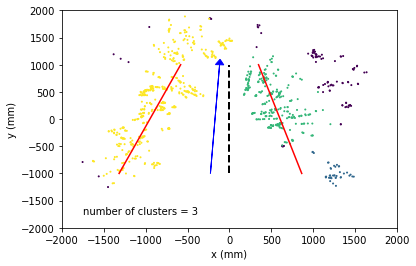

In [32]:
def dbscan(lidar_data, arrow=False, save=False, filename=None):
    clustering = DBSCAN(algorithm='auto', eps=300, leaf_size=30, metric='euclidean',
        metric_params=None, min_samples=30, n_jobs=1, p=None)
    clustering = clustering.fit(lidar_data)
    label = clustering.labels_

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.clear()
    ax.scatter(lidar_data[:,0], lidar_data[:,1], c=label, s=1)
    ax.set_xlim(left=-2000, right=2000)
    ax.set_ylim(bottom=-2000, top=2000)
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')
    # ax.set_title('LiDAR Scanning')

    # Draw center vertical line
    ax.vlines(x=0, ymin=-1000, ymax=1000, color = 'k', linewidth=2, linestyle='--')

    if arrow:
        x_data_array = []
        y_data_array = []
        x_0list = []
        y_0list = []
        x_mean_list= []
        label_array = []
        
        # TODO　應該可以簡化成不用雙迴圈
        # clustering 標籤類別
        for j in range(clustering.labels_.max() + 1): # TODO 修改成.max(), 避免空數值
            x_data_array = []
            y_data_array = []

            # 所有資料進行比對
            for i in range(len(lidar_data)):
                if clustering.labels_[i] == j:
                    xdata = lidar_data[:,0][i]
                    ydata = lidar_data[:,1][i]
                    label = clustering.labels_[i]

                    x_data_array.append(xdata)
                    y_data_array.append(ydata)
                    label_array.append(label)
        
            x_mean = np.mean(x_data_array)
            x_mean_list.append(x_mean)

        if len(x_mean_list) >= 2:
            # 求出大於 0 中最靠近 0 的數的索引
            x_mean_list = np.array(x_mean_list)
            gt_indices = np.where(x_mean_list > 0)[0]
            gt_min_index = np.argmin(np.abs(x_mean_list[gt_indices]))
            actual_gt_min_index = gt_indices[gt_min_index]

            # 求出小於 0 中最靠近 0 的數的索引
            lt_indices = np.where(x_mean_list < 0)[0]
            lt_min_index = np.argmin(np.abs(x_mean_list[lt_indices]))
            actual_lt_min_index = lt_indices[lt_min_index]
            actual_min_index = [actual_gt_min_index, actual_lt_min_index]
            print(f"min_distanse: [{x_mean_list[actual_lt_min_index]:.3f}, {x_mean_list[actual_gt_min_index]:.3f}]")
        

            # 跑兩次迴歸找最近的兩區域
            for j in actual_min_index:
                x_data_array = []
                y_data_array = []

                for i in range(len(lidar_data)):
                    if clustering.labels_[i] == j:
                        xdata = lidar_data[:,0][i]
                        ydata = lidar_data[:,1][i]
                        label = clustering.labels_[i]

                        x_data_array.append(xdata)
                        y_data_array.append(ydata)


                model = LinearRegression()
                x_0 = np.expand_dims(x_data_array, axis=1)
                y_0 = np.expand_dims(y_data_array, axis=1)
                model.fit(y_0, x_0)
                x_predict_0 = model.predict(y_0)

                x_0, y_0 = get_function(x_predict_0, y_0)
                plt.plot(x_0, y_0, c = 'red')
                x_0list.append(x_0)
                y_0list.append(y_0)


            # CREATE reference line
            x_c = (x_0list[0] + x_0list[1]) / 2
            y_c = (y_0list[0] + y_0list[1]) / 2
            lidar_angle, mid_dis = get_degree(x_c, y_c)
            plt.arrow(x_c[0], y_c[0], x_c[-1]-x_c[0], y_c[-1]-y_c[0], head_length=100, head_width=100, color="blue")
            
            print(f'Error output: angle = {90-lidar_angle:.3f}, dis = {mid_dis:.3f}')

    # 將群集數量顯示於圖上
    plt.text(x=-1750, y=-1750, s=f"number of clusters = {clustering.labels_.max() + 1}")

    if save == True:
        ax.set_title(filename)
        plt.savefig(f"output_dbscan/{filename}.jpg", dpi=300)
        plt.close(fig)
        return
    else:
        plt.show()



# # 單張測試
path = Path("ml_dataset/110.txt")
conver_to_2txt(path)
lidar_pos_x, lidar_pos_y, lidar_data = open_2_txt()
dbscan(lidar_data, arrow=True)

110 ,111, 115, 133, 有問題

157, 161 無法分群

min_distanse: [-217.510, 1526.714]
Error output: angle = -11.445, dis = 726.414


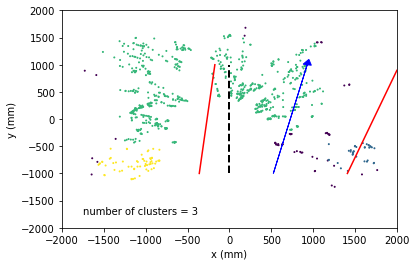

In [33]:
# 單張測試
path = Path("ml_dataset/111.txt")
conver_to_2txt(path)
lidar_pos_x, lidar_pos_y, lidar_data = open_2_txt()
dbscan(lidar_data, arrow=True)

#=========== All pictures ===========
# save_all_plt(type="dbscan", arrow=True)

## HDBSCAN

min_distanse: [-886.842, 945.153]
Error output: angle = 11.601, dis = 99.071


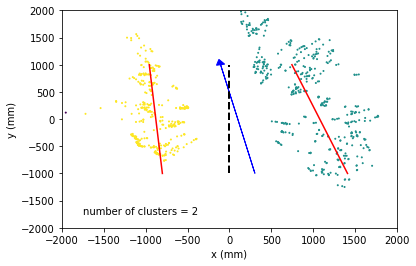

In [34]:
import hdbscan

def Hdbscan(lidar_data, arrow=False, save=False, filename=None):
    # clustering = DBSCAN(algorithm='auto', eps=300, leaf_size=30, metric='euclidean',
    #     metric_params=None, min_samples=30, n_jobs=1, p=None)
    clustering = hdbscan.HDBSCAN(min_cluster_size=70)


    clustering = clustering.fit(lidar_data)
    label = clustering.labels_

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.clear()
    ax.scatter(lidar_data[:,0], lidar_data[:,1], c=label, s=1)
    ax.set_xlim(left=-2000, right=2000)
    ax.set_ylim(bottom=-2000, top=2000)
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')
    # ax.set_title('LiDAR Scanning')

    # Draw center vertical line
    ax.vlines(x=0, ymin=-1000, ymax=1000, color='k', linewidth=2, linestyle='--')

    if arrow:
        x_data_array = []
        y_data_array = []
        x_0list = []
        y_0list = []
        x_mean_list= []
        label_array = []
        
        # TODO　應該可以簡化成不用雙迴圈
        # clustering 標籤類別
        for j in range(clustering.labels_.max() + 1): # TODO 修改成.max(), 避免空數值
            x_data_array = []
            y_data_array = []

            # 所有資料進行比對
            for i in range(len(lidar_data)):
                if clustering.labels_[i] == j:
                    xdata = lidar_data[:,0][i]
                    ydata = lidar_data[:,1][i]
                    label = clustering.labels_[i]

                    x_data_array.append(xdata)
                    y_data_array.append(ydata)
                    label_array.append(label)
        
            x_mean = np.mean(x_data_array)
            x_mean_list.append(x_mean)

        if len(x_mean_list) >= 2:
            # 求出大於 0 中最靠近 0 的數的索引
            x_mean_list = np.array(x_mean_list)
            gt_indices = np.where(x_mean_list > 0)[0]
            gt_min_index = np.argmin(np.abs(x_mean_list[gt_indices]))
            actual_gt_min_index = gt_indices[gt_min_index]

            # 求出小於 0 中最靠近 0 的數的索引
            lt_indices = np.where(x_mean_list < 0)[0]
            lt_min_index = np.argmin(np.abs(x_mean_list[lt_indices]))
            actual_lt_min_index = lt_indices[lt_min_index]
            actual_min_index = [actual_gt_min_index, actual_lt_min_index]
            print(f"min_distanse: [{x_mean_list[actual_lt_min_index]:.3f}, {x_mean_list[actual_gt_min_index]:.3f}]")
        

            # 跑兩次迴歸找最近的兩區域
            for j in actual_min_index:
                x_data_array = []
                y_data_array = []

                for i in range(len(lidar_data)):
                    if clustering.labels_[i] == j:
                        xdata = lidar_data[:,0][i]
                        ydata = lidar_data[:,1][i]
                        label = clustering.labels_[i]

                        x_data_array.append(xdata)
                        y_data_array.append(ydata)


                model = LinearRegression()
                x_0 = np.expand_dims(x_data_array, axis=1)
                y_0 = np.expand_dims(y_data_array, axis=1)
                model.fit(y_0, x_0)
                x_predict_0 = model.predict(y_0)

                x_0, y_0 = get_function(x_predict_0, y_0)
                plt.plot(x_0, y_0, c = 'red')
                x_0list.append(x_0)
                y_0list.append(y_0)


            # CREATE reference line
            x_c = (x_0list[0] + x_0list[1]) / 2
            y_c = (y_0list[0] + y_0list[1]) / 2
            lidar_angle, mid_dis = get_degree(x_c, y_c)
            plt.arrow(x_c[0], y_c[0], x_c[-1]-x_c[0], y_c[-1]-y_c[0], head_length=100, head_width=100, color="blue")
            
            print(f'Error output: angle = {90-lidar_angle:.3f}, dis = {mid_dis:.3f}')

    # 將群集數量顯示於圖上
    plt.text(x=-1750, y=-1750, s=f"number of clusters = {clustering.labels_.max() + 1}")

    if save == True:
        ax.set_title(filename)
        plt.savefig(f"output_dbscan/{filename}.jpg", dpi=300)
        plt.close(fig)
        return
    else:
        plt.show()
    plt.show()

        
# # 單張測試
path = Path("ml_dataset/120.txt")
conver_to_2txt(path)
lidar_pos_x, lidar_pos_y, lidar_data = open_2_txt()
Hdbscan(lidar_data, arrow=True)

Text(0.5, 1.0, '232')

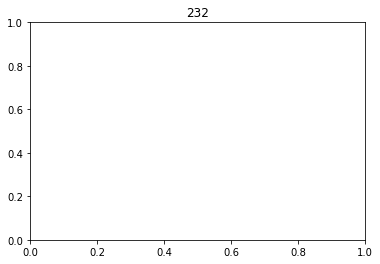

In [49]:
plt.title("232")
# lt.imlots[1,3], [2,3](w()